# EDA notebook
Also has data cleaning and feature engineering
- Polar coordinates
- outliers detection and removal
- nan value removal

Extra:
- Explore using histogram plot. 
- Instead of just meaning col, use other columns.

# Import

In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [2]:
%run utils.py
fractionOfData = 1
pd.options.mode.chained_assignment = None  # default='warn'


# Load data

## Metadata

In [3]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [4]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [5]:
metaData = pd.concat([metaData_apartment, metaData_building])
metaData

,name,type,desc,cats
0,apartment_id,integer_id,Unique ID for apartment,NaN
1,seller,categorical,The type of apartment seller,"[Owner, Company, Agents, Developer]"
2,price,real,The listed price of the apartment (TARGET),NaN
3,area_total,real,Total area of the apartment,NaN
4,area_kitchen,real,Total kitchen area in the apartment,NaN
5,area_living,real,Total living space area in the apartment,NaN
6,floor,integer,Primary building floor of the apartment,NaN
7,rooms,integer,Number of rooms in the apartment,NaN
8,layout,categorical,Overal apartment layout,"[Adjacent, Isolated, Adjacent_isolated]"
9,ceiling,real,Ceiling height in the apartment,NaN


In [6]:
pd.set_option('display.max_colwidth', None)
display(metaData.loc[metaData['name'] == "material"]["cats"])
display(metaData.loc[metaData['name'] == "district"]["cats"])
display(metaData.loc[metaData['name'] == "parking"]["cats"])

8    [Bricks, Wood, Monolith, Panel, Block, Monolithic_brick, Stalin_project]
Name: cats, dtype: object

4    [Central, North, North-East, East, South-East, South, South-West, West, North-West, Zelenograd, Troitsk, Novomoskovsk]
Name: cats, dtype: object

13    [Ground, Underground, Multilevel]
Name: cats, dtype: object

## Train data

In [7]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [8]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [9]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [10]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))

## Test data

In [11]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [12]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [13]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)

# Outliers

23197
23285


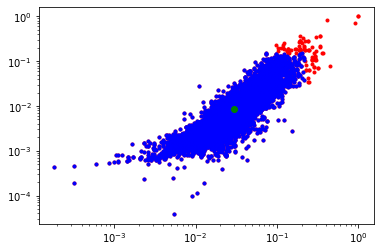

In [14]:
# Remove outlayers
outliers_value = 7
some_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", "price"]

normalized_train = train[some_features]
normalized_train = (normalized_train-normalized_train.min())/(normalized_train.max()-normalized_train.min())

# Can remove outlayers based on 
no_outlayers = normalized_train[(np.abs(stats.zscore(normalized_train[["area_total", "price"]])) < outliers_value).all(axis=1)]
print(len(no_outlayers))
print(len(normalized_train))

plt.plot(normalized_train['area_total'], normalized_train['price'], 'r.')
plt.plot(no_outlayers['area_total'], no_outlayers['price'], 'b.')
plt.plot(normalized_train['area_total'].mean(), normalized_train['price'].mean(), 'og')
plt.xscale("log")
plt.yscale("log")
plt.show()


# Polar coordinates

In [96]:
# "All" numerical features
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]
outliers_value = 7

# Outlayer removal
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[numerical_features]
labels1 = labels1.fillna(labels1.mean())
targets1= no_outlayers['price'] # Non nan values here.

# Test
test1 = test[numerical_features]
test1 = test1.fillna(test1.mean())

# Normalize
normalized_labels1 = (labels1-labels1.min())/(labels1.max()-labels1.min())
normalized_test1 = (test1-test1.min())/(test1.max()-test1.min())

In [97]:
# Make a copy
labels1_normed_r = normalized_labels1.copy()
test1_normed_r = normalized_test1.copy()

# Move origo to centre
labels1_normed_r['latitude'] = labels1_normed_r['latitude'] -  labels1_normed_r['latitude'].mean()
labels1_normed_r['longitude'] = labels1_normed_r['longitude'] -  labels1_normed_r['longitude'].mean()
test1_normed_r['latitude'] = test1_normed_r['latitude'] -  test1_normed_r['latitude'].mean()
test1_normed_r['longitude'] = test1_normed_r['longitude'] -  test1_normed_r['longitude'].mean()

# Convert to polar coordinates
labels1_normed_r['r'] =  np.sqrt(labels1_normed_r['latitude']**2 + labels1_normed_r['longitude']**2)
labels1_normed_r['theta'] = np.arctan(labels1_normed_r['longitude']/labels1_normed_r['latitude'])
test1_normed_r['r'] =  np.sqrt(test1_normed_r['latitude']**2 + test1_normed_r['longitude']**2)
test1_normed_r['theta'] = np.arctan(test1_normed_r['longitude']/test1_normed_r['latitude'])

[-5.973006572971485e-17, -3.308126717338053e-17]


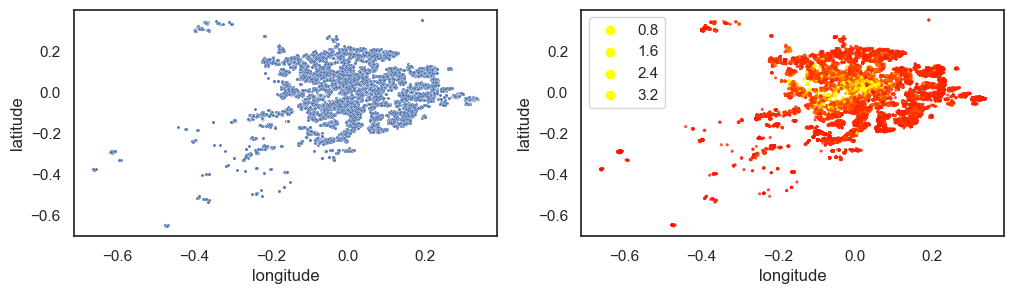

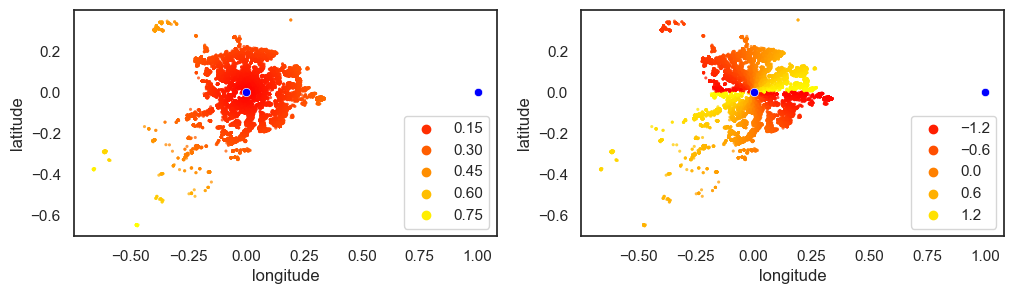

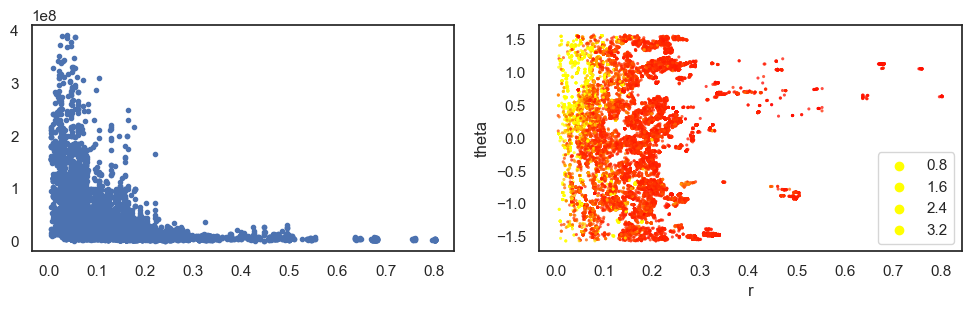

In [106]:
# Cartesian plot
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
lo, hi = targets1.quantile([0.0, 0.9])
hue_norm = plt.Normalize(lo, hi)
hue = targets1.tolist()

sns.scatterplot(x='longitude', y='latitude', ax=ax1, alpha=1, s=5, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(x='longitude', y='latitude', ax=ax2, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['latitude', 'longitude']])

# 
fig, (ax5, ax6) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
hue=labels1_normed_r['r'].tolist()
sns.scatterplot(x='longitude', y='latitude', ax=ax5, hue=hue, palette="autumn", alpha=0.75, s=5, linewidth=0, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(ax=ax5, color="blue", data=[labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean() ])

hue=labels1_normed_r['theta'].tolist()
sns.scatterplot(x='longitude', y='latitude', ax=ax6, hue=hue, palette="autumn", alpha=0.75, s=5, linewidth=0, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(ax=ax6, color="blue", data=[labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean() ])
print([labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean()])

## Polar plot
hue = targets1.tolist()
fig, (ax3, ax4) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
#sns.scatterplot(x='r', y='theta', ax=ax3, alpha=1, s=5, data=labels1_normed_r[['r', 'theta']])
sns.scatterplot(x='r', y='theta', ax=ax4, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['r', 'theta']])

ax3.plot(labels1_normed_r['r'], targets1, ".")
plt.show()

## Correlations, drop and nan

Left plot is removing nan values, right uses mean()


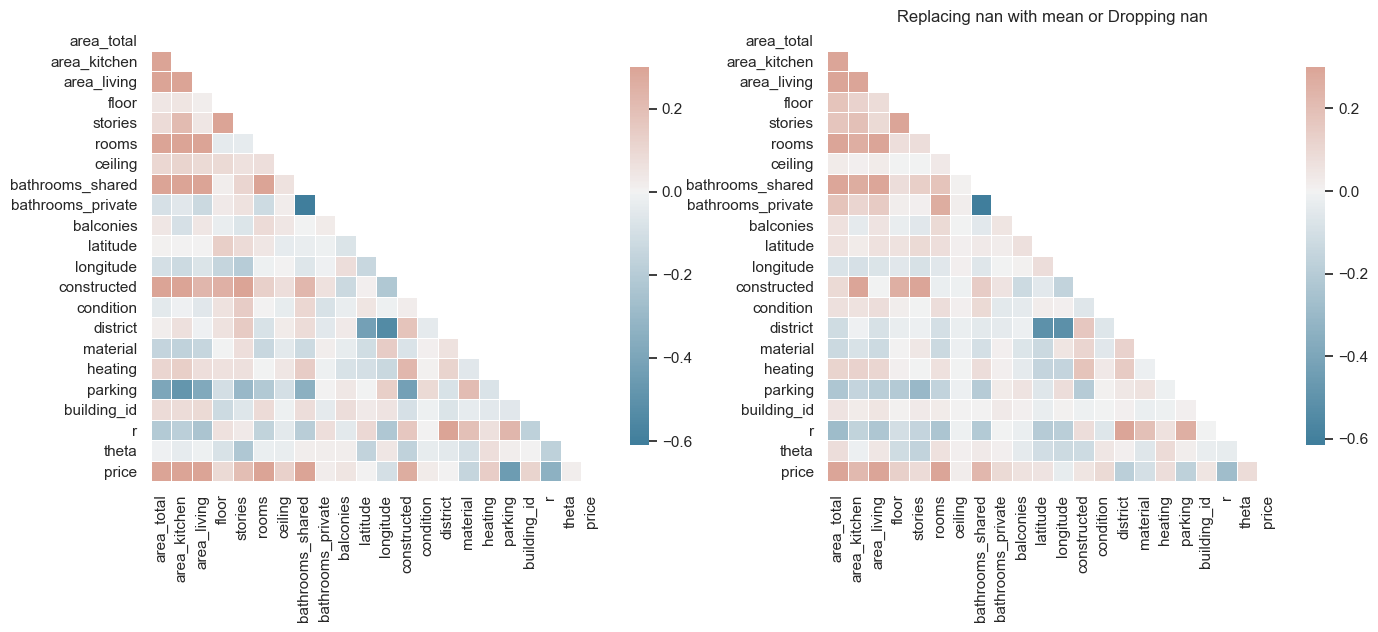

In [271]:
corr_dataframe = pd.merge(labels_n_r, targets, left_index=True, right_index=True)
corr_dataframe2 = pd.merge(labels2_n_r, targets2, left_index=True, right_index=True)
# Compute the correlation matrix
corr = corr_dataframe.corr()
corr2 = corr_dataframe2.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
mask2 = np.triu(np.ones_like(corr2, dtype=bool))
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(figsize=(16, 10), ncols=2, dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
sns.heatmap(corr, ax=ax1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Replacing nan with mean or Dropping nan')
sns.heatmap(corr2, ax=ax2, mask=mask2, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

print("Left plot is removing nan values, right uses mean()")

### What features correlates with price?
Positive correlations:
- Area total, then area living then area kitchen.
- Rooms
- Shared bathrooms
- Constructed
- Stories
- Floor

Negative correlations:
- District
- Material
- Parking
- R

In [273]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", # Numerical
           "condition", "district", "material", "heating", "parking", "building_id"]

# Extract labels, targets and preprocess
labels_n, test_n, targets = preProcess_numericalData(features, train, test, outliers_value=100)
labels_n_r, test_n_r = polar_coordinates(labels_n, test_n)

# Drop useless cols
labels_n_r = labels_n_r.drop(['latitude', 'longitude', 'theta'], 1)
test_n_r = test_n_r.drop(['latitude', 'longitude', 'theta'], 1)

<AxesSubplot:>

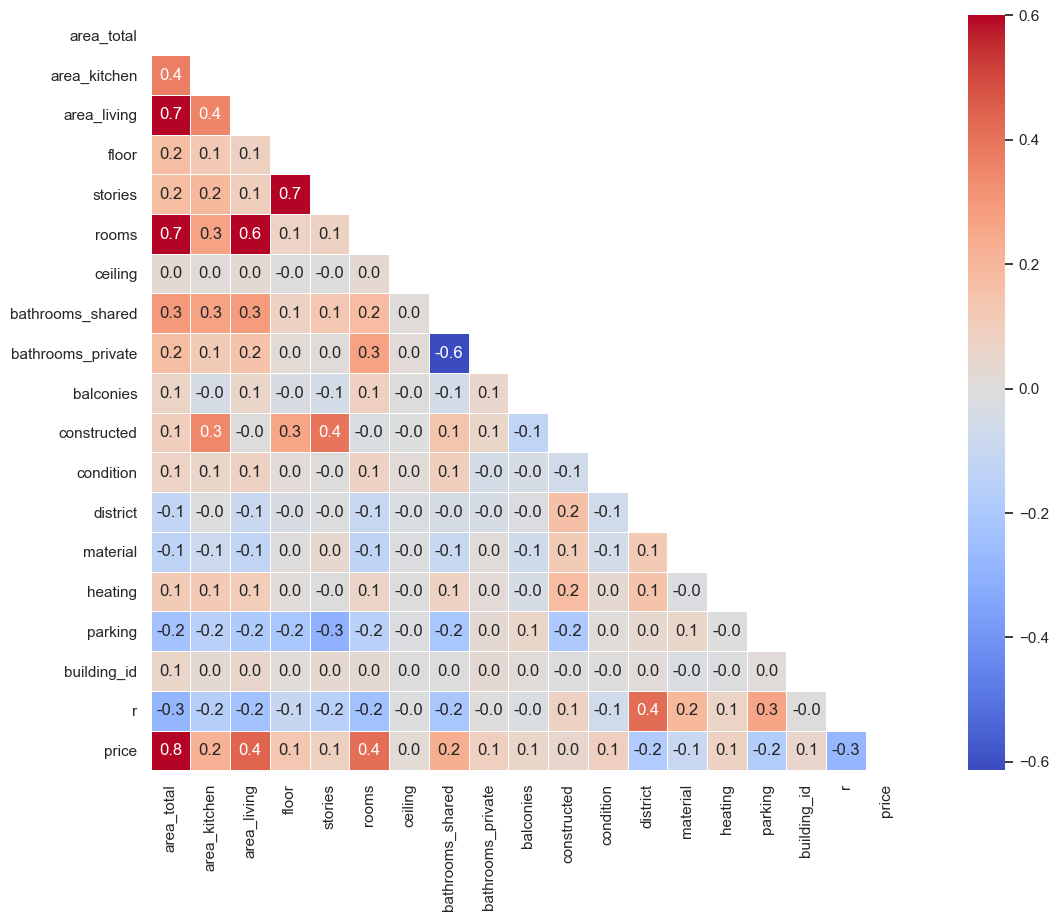

In [274]:
df_all = pd.merge(labels_n_r, targets, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

# Floor/stories
Neither floors nor stories are very correlated to price. What about a floor/stories value?


Explaination of the new features:
- Penthouse: it is the top floor (if floor == stories)
- rel_height: the float value of floor/stories - so a float between 0-1, which is 1 for penthouses
- high-up: upper half of a building, which is above ten stories.
- real_penhouse: is a pentouse of a building with 10 or more stories.

Then the _e tag at the end means that there is also elevator access in the building for passengers.
And the _e_w tag means there are some apartments in the building without elevator for passengers

In [260]:
# Make a copy
# "All" numerical features
features = ["floor", "stories", "elevator_without", "elevator_passenger", "elevator_service"]
outliers_value = 100


# Outlayer and NAN removal!
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

# New col - rel_height
labels1['rel_height'] = labels1["floor"] / labels1["stories"]
labels1['penthouse'] = labels1["floor"]==labels1["stories"]
labels1['high_up'] = (labels1['rel_height']>0.5) & (labels1['stories']>10)
labels1['real_penthouse'] = (labels1['stories']>10) & (labels1['penthouse'])

# Elevator
labels1['penthouse_e'] = (labels1['penthouse']) & (labels1['elevator_passenger'])
labels1['high_up_e'] = (labels1['high_up']) & (labels1['elevator_passenger'])
labels1['real_penthouse_e'] = (labels1['real_penthouse']) & (labels1['elevator_passenger'])

# Lacks elevator
labels1['penthouse_e_w'] = (labels1['penthouse']) & (labels1['elevator_without'])
labels1['high_up_e_w'] = (labels1['high_up']) & (labels1['elevator_without'])
labels1['real_penthouse_e_w'] = (labels1['real_penthouse']) & (labels1['elevator_without'])



In [261]:
labels1['elevator_without'].value_counts()

0.00000    13926
1.00000     9002
0.39262      357
Name: elevator_without, dtype: int64

In [262]:
labels1['penthouse'].value_counts()

False    21593
True      1692
Name: penthouse, dtype: int64

In [266]:
df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
print(df_all.groupby("penthouse")["price"].mean())
print(df_all.groupby("penthouse_e")["price"].mean())
print(df_all.groupby("penthouse_e_w")["price"].mean())
print(df_all.groupby("high_up")["price"].mean())
print(df_all.groupby("high_up_e")["price"].mean())
print(df_all.groupby("high_up_e_w")["price"].mean())
print(df_all.groupby("real_penthouse")["price"].mean())
print(df_all.groupby("real_penthouse_e")["price"].mean())
print(df_all.groupby("real_penthouse_e_w")["price"].mean())

penthouse
False    2.286944e+07
True     3.232020e+07
Name: price, dtype: float64
penthouse_e
False    2.277103e+07
True     3.617431e+07
Name: price, dtype: float64
penthouse_e_w
False    2.276663e+07
True     4.664275e+07
Name: price, dtype: float64
high_up
False    2.303227e+07
True     2.459225e+07
Name: price, dtype: float64
high_up_e
False    2.307272e+07
True     2.452676e+07
Name: price, dtype: float64
high_up_e_w
False    2.149911e+07
True     3.784124e+07
Name: price, dtype: float64
real_penthouse
False    2.324842e+07
True     3.235400e+07
Name: price, dtype: float64
real_penthouse_e
False    2.324515e+07
True     3.261414e+07
Name: price, dtype: float64
real_penthouse_e_w
False    2.305061e+07
True     7.357480e+07
Name: price, dtype: float64


<AxesSubplot:>

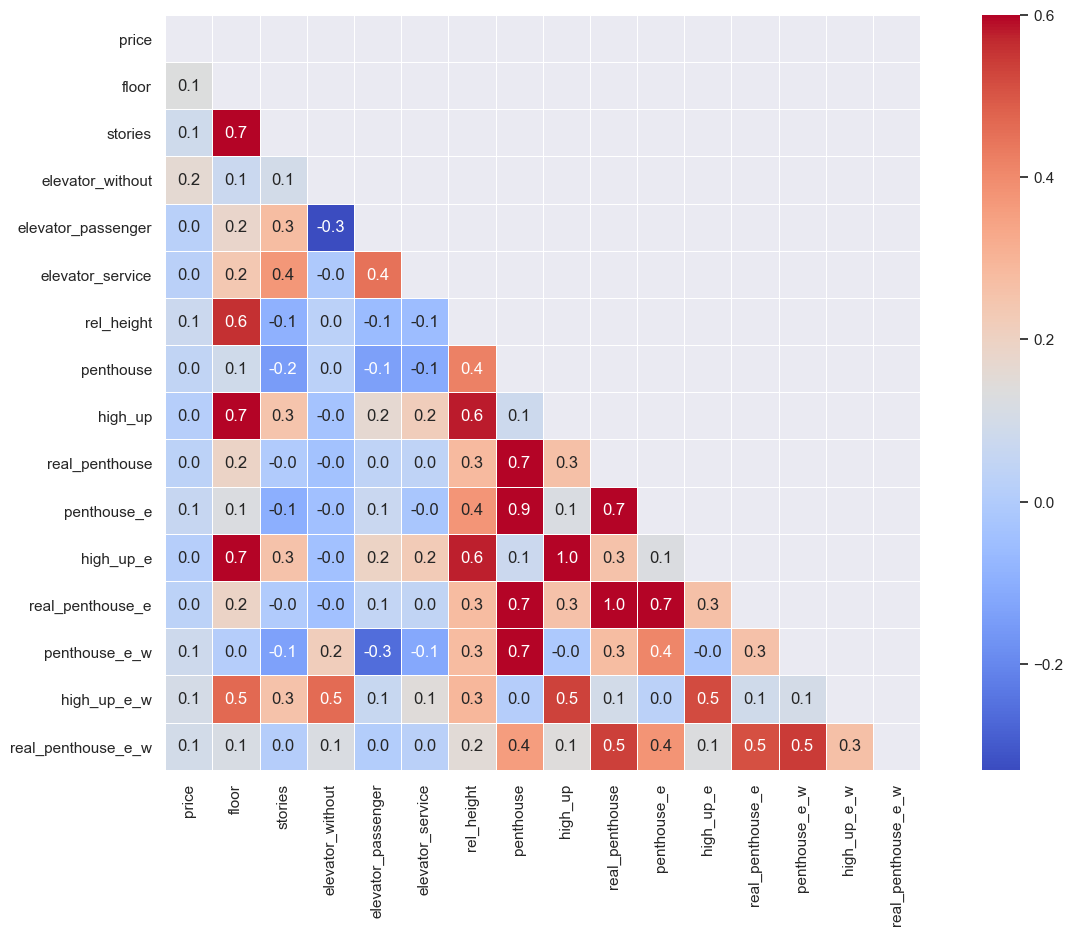

In [269]:
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### WHY DO PEOPLE NOT LIKE ELEVATORS??

## Booleans

<AxesSubplot:>

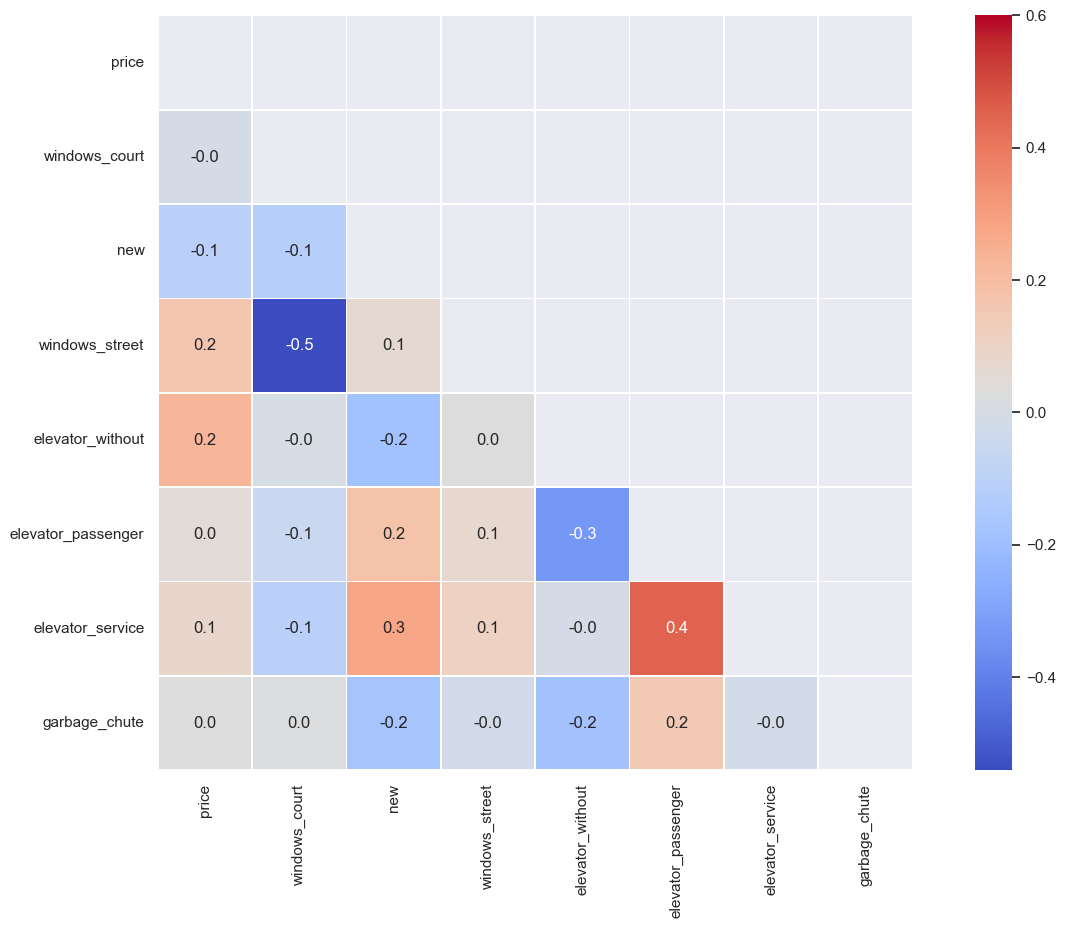

In [19]:
# Make a copy
# "All" numerical features
features = ["windows_court","new", "windows_street", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"]
outliers_value = 4

no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### Spaciousness

<AxesSubplot:>

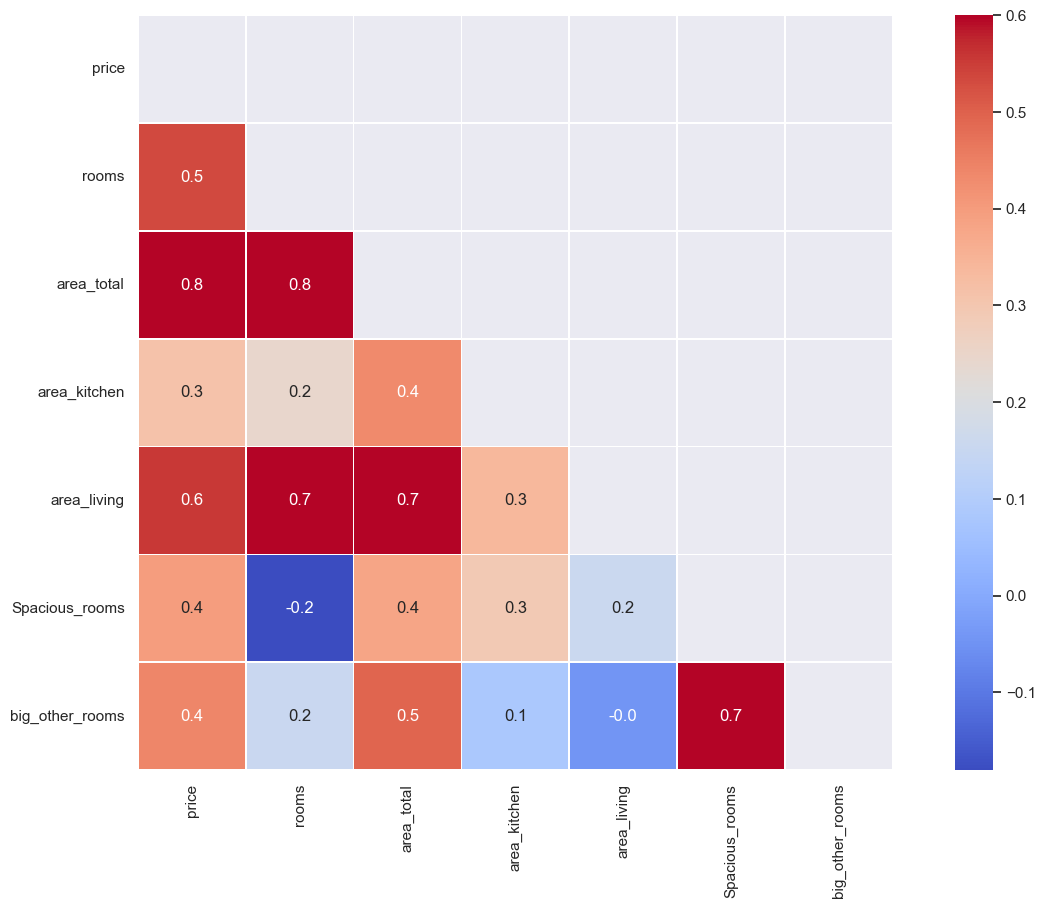

In [22]:
# Make a copy
# "All" numerical features
features = ["rooms", "area_total", "area_kitchen", "area_living"]
outliers_value = 4

no_outlayers = train[(np.abs(stats.zscore(train[["price", "area_total"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

#
labels1['Spacious_rooms'] = labels1['area_total'] /labels1['rooms']
#labels1['big_kitchen'] = labels1['area_kitchen'] /labels1['area_total']
#labels1['big_living_room'] = labels1['area_living'] /labels1['area_total']
labels1['big_other_rooms'] = (labels1['area_total']-labels1['area_kitchen']-labels1['area_living']) / labels1['rooms']


df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### One hot encoding!

In [39]:
%run ../common_utils.py

In [43]:
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String
features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = []

In [44]:
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="none",
                    add_R=False, add_rel_height=False, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True)

#train_labels, train_targets, val_labels, val_targets, test_labels =

<AxesSubplot:>

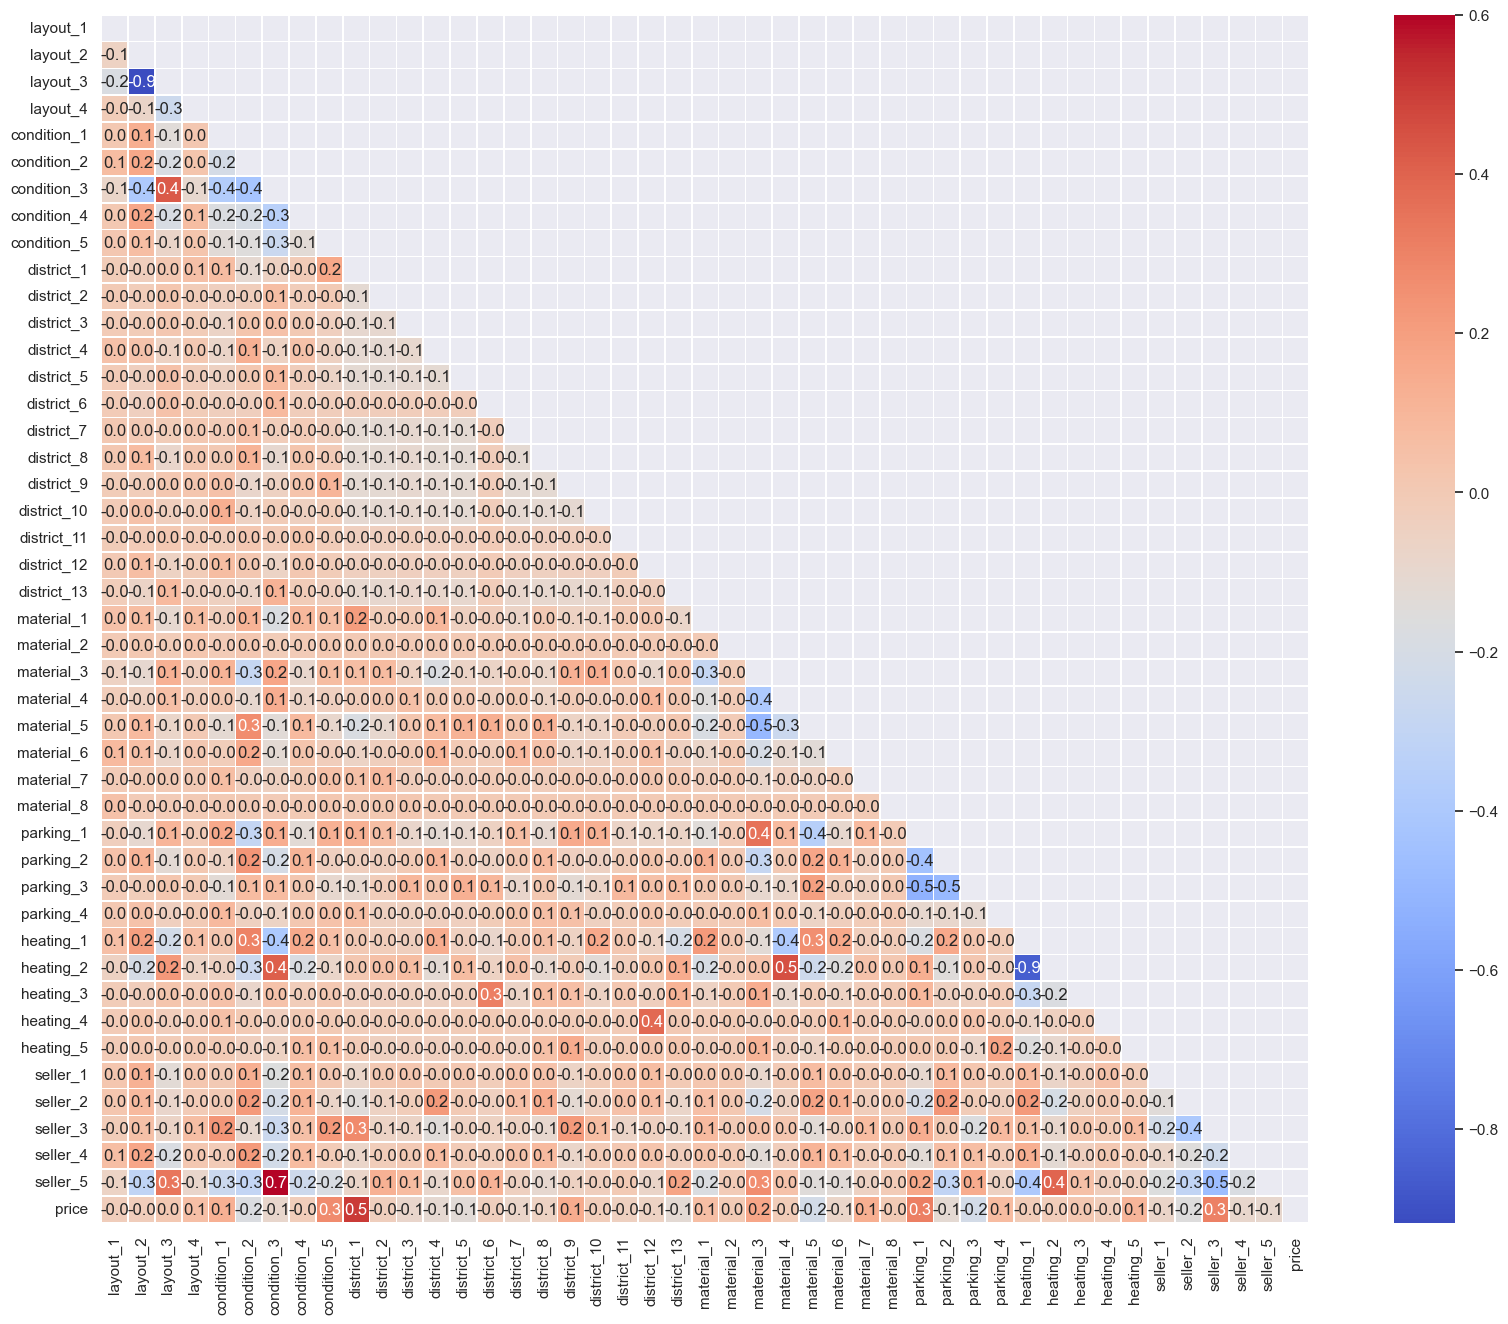

In [45]:
df_all = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(22, 16), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

In [47]:
import xgboost

In [48]:
# PRoblem this only show linear correlation. Lets look for non-linear ones!
model = xgboost.XGBRegressor()
model.fit(train_labels,train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

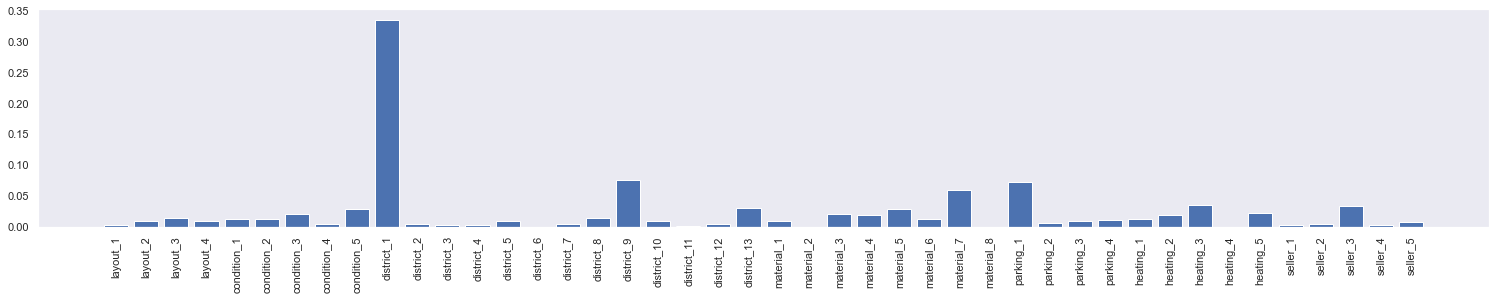

In [50]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# The NAN values- use other cols to insert nans!

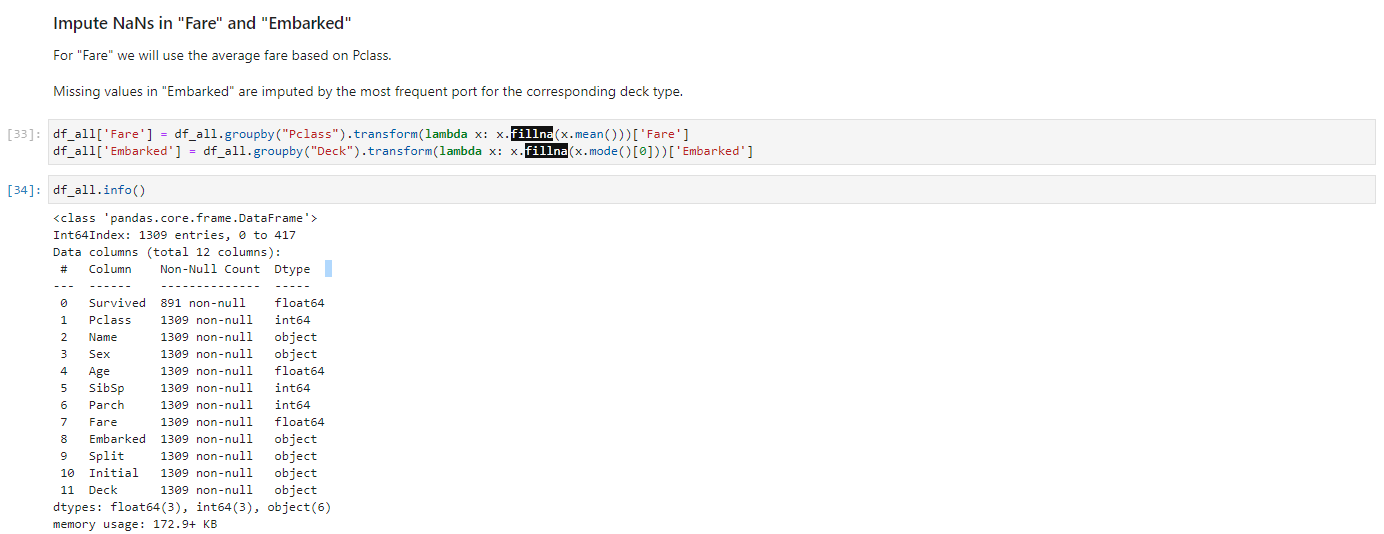

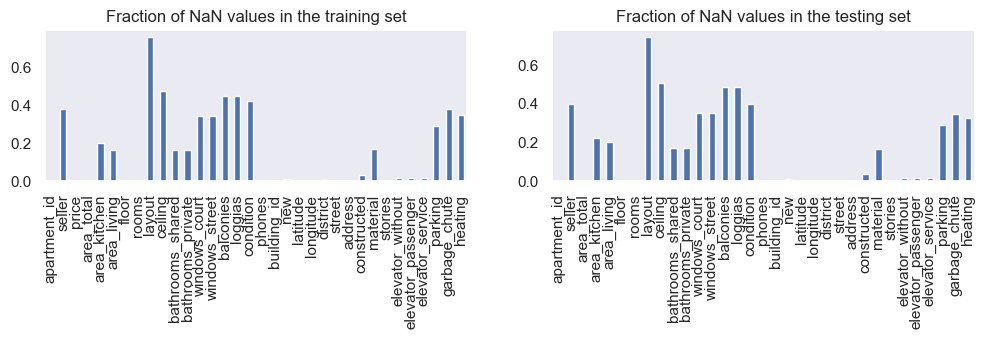

In [58]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 2), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

In [91]:
metaData

,name,type,desc,cats
0,apartment_id,integer_id,Unique ID for apartment,NaN
1,seller,categorical,The type of apartment seller,"[Owner, Company, Agents, Developer]"
2,price,real,The listed price of the apartment (TARGET),NaN
3,area_total,real,Total area of the apartment,NaN
4,area_kitchen,real,Total kitchen area in the apartment,NaN
5,area_living,real,Total living space area in the apartment,NaN
6,floor,integer,Primary building floor of the apartment,NaN
7,rooms,integer,Number of rooms in the apartment,NaN
8,layout,categorical,Overal apartment layout,"[Adjacent, Isolated, Adjacent_isolated]"
9,ceiling,real,Ceiling height in the apartment,NaN


In [90]:
pd.set_option('display.max_colwidth', None)
print(metaData.loc[metaData['name'] == "material"]["cats"])
display(metaData.loc[metaData['name'] == "material"]["cats"])
display(metaData.loc[metaData['name'] == "district"]["cats"])
display(metaData.loc[metaData['name'] == "parking"]["cats"])



8    [Bricks, Wood, Monolith, Panel, Block, Monolithic_brick, Stalin_project]
Name: cats, dtype: object


8    [Bricks, Wood, Monolith, Panel, Block, Monolithic_brick, Stalin_project]
Name: cats, dtype: object

4    [Central, North, North-East, East, South-East, South, South-West, West, North-West, Zelenograd, Troitsk, Novomoskovsk]
Name: cats, dtype: object

13    [Ground, Underground, Multilevel]
Name: cats, dtype: object

In [94]:
meta_cat = metaData.loc[metaData['type']=="categorical"]

In [111]:
len(metaData.loc[metaData['type']=="categorical"].loc[metaData.loc[metaData['type']=="categorical"]["name"]=="material"].cats.tolist()[0])

7